<a href="https://colab.research.google.com/github/Sara-V11/TrustLedger/blob/main/TrustLedger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --quiet torch-geometric -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install --quiet networkx pandas scikit-learn matplotlib tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.5 MB/s eta 0:00:00


In [3]:
import torch
import torch_geometric

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))
print("PyG version:", torch_geometric.__version__)

PyTorch version: 2.8.0+cu126
CUDA available: True
Device: Tesla T4
PyG version: 2.7.0


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
import pandas as pd
import networkx as nx
import torch
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!ls /content/drive/MyDrive

'07- CS F372 OS Process Management-II.gslides'
 1.gdoc
'2022A7PS0049U-SaraVartak-dalil (1).pdf'
 2022A7PS0049U-SaraVartak-dalil.pdf
 2022A7PS0049U-SaraVartak-Dalil.pdf
 2022A7PS0049u-SaraVartak-Deriv.pdf
'2022A7PS0049U-SaraVartak-DubaiIslamicBank .pdf.pdf'
'2022A7PS0049U-SaraVartak-EmiratesDubai .pdf.pdf'
'2022A7PS0049U-SaraVartak-Emqube .pdf.pdf'
 2022A7PS0049U-SaraVartak-ESRI.pdf
'2022A7PS0049U-Sara Vartak-Flamingus Technologies LLC,Dubai .pdf'
'2022A7PS0049U-SaraVartak-HashGate .pdf.pdf'
'2022A7PS0049U-SaraVartak-MSD (1).pdf'
'2022A7PS0049U-SaraVartak-MSD (2).pdf'
'2022A7PS0049U-SaraVartak-MSD (3).pdf'
'2022A7PS0049U-SaraVartak-MSD-DataScience (1).pdf'
 2022A7PS0049U-SaraVartak-MSD-DataScience.pdf
 2022A7PS0049U-SaraVartak-MSD-Digsol.pdf
 2022A7PS0049U-SaraVartak-MSD-MedicalAffairs.pdf
 2022A7PS0049U-SaraVartak-MSD.pdf
'2022A7PS0049U-SaraVartak-OasisInvestmentDubai .pdf.pdf'
'2022A7PS0049U-SaraVartak-Omniclouds,Dubai .pdf.pdf'
 2022A7PS0049U-SaraVartak.pdf
 2022A7PS0049U-SaraVartak-

In [8]:
!ls /content/drive/MyDrive/FinanceProject/FraudData.csv

/content/drive/MyDrive/FinanceProject/FraudData.csv


In [9]:
import pandas as pd

file_path = '/content/drive/MyDrive/FinanceProject/FraudData.csv'
data = pd.read_csv(file_path)
print(data.head())


   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [10]:
file_path = '/content/drive/MyDrive/FinanceProject/FraudData.csv'

In [11]:
df = pd.read_csv(file_path)
df = df.sample(50000, random_state=42)
df.columns = df.columns.str.strip()
print("Data loaded successfully!")

print(df.head())

Data loaded successfully!
         step      type      amount     nameOrig  oldbalanceOrg  \
3737323   278   CASH_IN   330218.42   C632336343       20866.00   
264914     15   PAYMENT    11647.08  C1264712553       30370.00   
85647      10   CASH_IN   152264.21  C1746846248      106589.00   
5899326   403  TRANSFER  1551760.63   C333676753           0.00   
2544263   206   CASH_IN    78172.30   C813403091     2921331.58   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
3737323       351084.42   C834976624       452419.57       122201.15        0   
264914         18722.92   M215391829            0.00            0.00        0   
85647         258853.21  C1607284477       201303.01        49038.80        0   
5899326            0.00  C1564353608      3198359.45      4750120.08        0   
2544263      2999503.88  C1091768874       415821.90       337649.60        0   

         isFlaggedFraud  
3737323               0  
264914                0  
85647 

In [12]:
print(df.columns)

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')


In [13]:
print(df.head())

         step      type      amount     nameOrig  oldbalanceOrg  \
3737323   278   CASH_IN   330218.42   C632336343       20866.00   
264914     15   PAYMENT    11647.08  C1264712553       30370.00   
85647      10   CASH_IN   152264.21  C1746846248      106589.00   
5899326   403  TRANSFER  1551760.63   C333676753           0.00   
2544263   206   CASH_IN    78172.30   C813403091     2921331.58   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
3737323       351084.42   C834976624       452419.57       122201.15        0   
264914         18722.92   M215391829            0.00            0.00        0   
85647         258853.21  C1607284477       201303.01        49038.80        0   
5899326            0.00  C1564353608      3198359.45      4750120.08        0   
2544263      2999503.88  C1091768874       415821.90       337649.60        0   

         isFlaggedFraud  
3737323               0  
264914                0  
85647                 0  
589932

In [14]:
# Strip any hidden whitespace in column names
df.columns = df.columns.str.strip()

In [15]:
#Preprocess data
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [16]:
# Encode account IDs
from sklearn.preprocessing import LabelEncoder
all_accounts = pd.concat([df['nameOrig'], df['nameDest']]).unique()
le = LabelEncoder()
le.fit(all_accounts)

df['src'] = le.transform(df['nameOrig'])
df['dst'] = le.transform(df['nameDest'])

In [17]:
# Normalize amount and step
scaler = StandardScaler()
df[['amount', 'step']] = scaler.fit_transform(df[['amount', 'step']])

In [18]:
# Keep relevant columns
df = df[['src', 'dst', 'amount', 'step', 'isFraud'] + [c for c in df.columns if c.startswith('type_')]]

print("\n Data after preprocessing:")
print(df.head())


 Data after preprocessing:
           src    dst    amount      step  isFraud  type_CASH_OUT  type_DEBIT  \
3737323  65672  74386  0.277967  0.241107        0          False       False   
264914   11253  91233 -0.312543 -1.598207        0          False       False   
85647    31384  25546 -0.051892 -1.633175        0          False       False   
5899326  53308  23759  2.542243  1.115305        0          False       False   
2544263  73497   3893 -0.189231 -0.262431        0          False       False   

         type_PAYMENT  type_TRANSFER  
3737323         False          False  
264914           True          False  
85647           False          False  
5899326         False           True  
2544263         False          False  


In [19]:
# Step 5: Build transaction graph
G = nx.DiGraph()
for _, row in tqdm(df.iterrows(), total=len(df)):
    G.add_edge(
        row['src'],
        row['dst'],
        amount=row['amount'],
        step=row['step'],
        isFraud=row['isFraud']
    )

print(f"\n Graph built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


100%|██████████| 50000/50000 [00:03<00:00, 16388.65it/s]



 Graph built: 98083 nodes, 50000 edges


In [20]:
#Step 6: Convert to PyTorch Geometric data format
data = from_networkx(G)

node_mapping = {n:i for i,n in enumerate(G.nodes())}   # G node key -> PyG index
inv_mapping = {i:n for n,i in node_mapping.items()}    # PyG index -> G node key

edge_attr = []
for i in range(data.edge_index.shape[1]):
    u_idx = data.edge_index[0,i].item()
    v_idx = data.edge_index[1,i].item()
    u = inv_mapping[u_idx]
    v = inv_mapping[v_idx]
    edge_data = G[u][v]
    edge_attr.append([edge_data['amount'], edge_data['step']])

data.edge_attr = torch.tensor(edge_attr, dtype=torch.float)


In [21]:
node_degrees = torch.tensor([val for _, val in G.degree()], dtype=torch.float).view(-1,1)
node_in_degree = torch.tensor([val for _, val in G.in_degree()], dtype=torch.float).view(-1,1)
node_out_degree = torch.tensor([val for _, val in G.out_degree()], dtype=torch.float).view(-1,1)

In [22]:
num_nodes = G.number_of_nodes()
node_amount = torch.zeros(num_nodes,1)
for u,v,d in G.edges(data=True):
    node_amount[u] += d['amount']
    node_amount[v] += d['amount']

In [23]:
# Combine features
data.x = torch.cat([node_degrees, node_in_degree, node_out_degree, node_amount], dim=1)

In [24]:
# Node labels: fraudulent node = if it sent or received a fraud tx
labels = []
for node in G.nodes():
    edges_out = G.out_edges(node, data=True)
    edges_in = G.in_edges(node, data=True)
    fraud_edges = [d['isFraud'] for _, _, d in list(edges_out) + list(edges_in)]
    labels.append(1 if sum(fraud_edges)>0 else 0)
data.y = torch.tensor(labels, dtype=torch.long)

In [25]:
print(f"Fraudulent nodes: {(data.y==1).sum().item()}, Legitimate nodes: {(data.y==0).sum().item()}")

print("\nGraph Data Summary:")
print(data)

Fraudulent nodes: 140, Legitimate nodes: 97943

Graph Data Summary:
Data(edge_index=[2, 50000], amount=[50000], step=[50000], isFraud=[50000], num_nodes=98083, edge_attr=[50000, 2], x=[98083, 4], y=[98083])


In [26]:
from torch_geometric.nn import NNConv

In [27]:
print("Sanity checks before model creation:")
print("data.x.shape:", data.x.shape)                    # (num_nodes, num_node_features)
print("data.edge_index.shape:", data.edge_index.shape)  # (2, num_edges)
print("data.edge_attr.shape:", data.edge_attr.shape)    # (num_edges, edge_feat_dim)
print("data.y.shape:", data.y.shape)                    # (num_nodes,)

num_nodes = data.x.shape[0]
num_edges = data.edge_index.shape[1]
edge_feat_dim = data.edge_attr.shape[1]
node_feat_dim = data.x.shape[1]

assert data.edge_attr.shape[0] == num_edges, "edge_attr rows must equal number of edges"
assert data.x.shape[0] == data.y.shape[0], "number of nodes must equal number of labels"
assert edge_feat_dim == 2, "expected edge feature dim == 2 (amount, step) -- update if different"

print("Sanity checks passed.\n")

Sanity checks before model creation:
data.x.shape: torch.Size([98083, 4])
data.edge_index.shape: torch.Size([2, 50000])
data.edge_attr.shape: torch.Size([50000, 2])
data.y.shape: torch.Size([98083])
Sanity checks passed.



In [28]:
# Step 7: Define GCN model
class EdgeGCN_Fixed(torch.nn.Module):
    def __init__(self, node_in, edge_in, hidden, out):
        super(EdgeGCN_Fixed, self).__init__()
        self.edge_mlp1 = torch.nn.Sequential(
            torch.nn.Linear(edge_in, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, node_in * hidden)
        )
        self.edge_mlp2 = torch.nn.Sequential(
            torch.nn.Linear(edge_in, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, hidden * hidden)
        )

        self.conv1 = NNConv(node_in, hidden, self.edge_mlp1, aggr='mean')
        self.conv2 = NNConv(hidden, hidden, self.edge_mlp2, aggr='mean')
        self.lin = torch.nn.Linear(hidden, out)

    def forward(self, x, edge_index, edge_attr):
        # first conv
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)

        # second conv
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)

        x = self.lin(x)
        return x

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EdgeGCN_Fixed(node_in=node_feat_dim, edge_in=edge_feat_dim, hidden=32, out=2).to(device)
data = data.to(device)

# quick forward pass (no grad) to check runtime shapes
model.eval()
with torch.no_grad():
    out_sample = model(data.x, data.edge_index, data.edge_attr)
print("Quick forward pass output shape:", out_sample.shape)  # expect (num_nodes, 2)

Quick forward pass output shape: torch.Size([98083, 2])


In [30]:
#Train model
counts = torch.bincount(data.y)
weight_0 = 1.0
weight_1 = (counts[0] / counts[1]).item() if counts[1] > 0 else 1.0
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([weight_0, weight_1], device=device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print("\n Training started (fixed model)...")
for epoch in range(1, 31):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)   # pass edge_attr (already on device)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()

    pred = out.argmax(dim=1)
    acc = int((pred == data.y).sum()) / len(data.y)
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Accuracy: {acc:.4f}")
print("Training finished.")


 Training started (fixed model)...
Epoch 01 | Loss: 0.9051 | Accuracy: 0.9873
Epoch 05 | Loss: 0.5897 | Accuracy: 0.9543
Epoch 10 | Loss: 0.5891 | Accuracy: 0.9065
Epoch 15 | Loss: 0.5761 | Accuracy: 0.8042
Epoch 20 | Loss: 0.5643 | Accuracy: 0.5745
Epoch 25 | Loss: 0.5608 | Accuracy: 0.5842
Epoch 30 | Loss: 0.5613 | Accuracy: 0.7253
Training finished.


In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

In [32]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index, data.edge_attr)
    probs = F.softmax(out, dim=1)[:, 1]
    threshold = 0.8
    pred = (probs > threshold).long()

precision = precision_score(data.y.cpu(), pred.cpu())
recall = recall_score(data.y.cpu(), pred.cpu())
f1 = f1_score(data.y.cpu(), pred.cpu())

In [33]:

print("\n EVALUATION RESULTS ")
print(f"Detected {pred.sum().item()} potential fraudulent accounts")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


 EVALUATION RESULTS 
Detected 2950 potential fraudulent accounts
Precision: 0.0156
Recall: 0.3286
F1-score: 0.0298


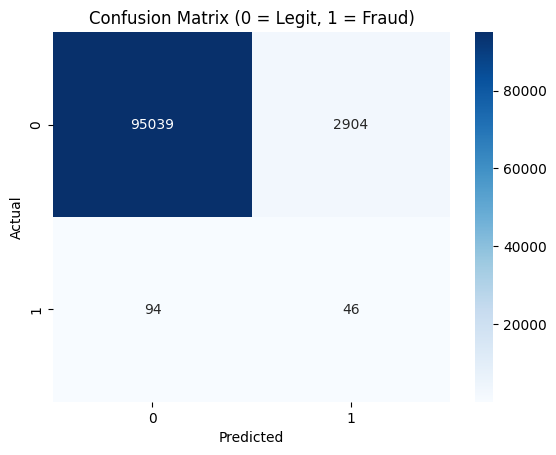

In [34]:
# Confusion matrix
cm = confusion_matrix(data.y.cpu(), pred.cpu())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (0 = Legit, 1 = Fraud)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [35]:
print("\nClassification Report:")
print(classification_report(data.y.cpu(), pred.cpu(), target_names=["Legit", "Fraud"]))


Classification Report:
              precision    recall  f1-score   support

       Legit       1.00      0.97      0.98     97943
       Fraud       0.02      0.33      0.03       140

    accuracy                           0.97     98083
   macro avg       0.51      0.65      0.51     98083
weighted avg       1.00      0.97      0.98     98083



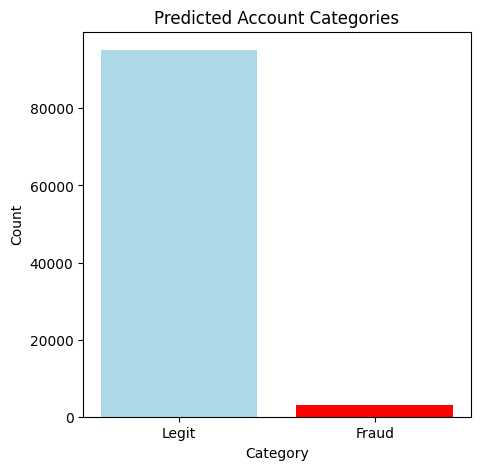

In [36]:
#Step 9: Visualization

# Fraud vs Legit Bar Plot
plt.figure(figsize=(5,5))
plt.bar(['Legit', 'Fraud'], [(pred==0).sum().item(), (pred==1).sum().item()], color=['lightblue', 'red'])
plt.title("Predicted Account Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

# Visualize a small transaction subgraph
import networkx as nx

# Select subset of nodes for visualization
sub_nodes = list(range(300))
sub_edges = [(u, v) for u, v in zip(data.edge_index[0].cpu().numpy(), data.edge_index[1].cpu().numpy())
             if u in sub_nodes and v in sub_nodes]

subG = nx.DiGraph()
subG.add_edges_from(sub_edges)


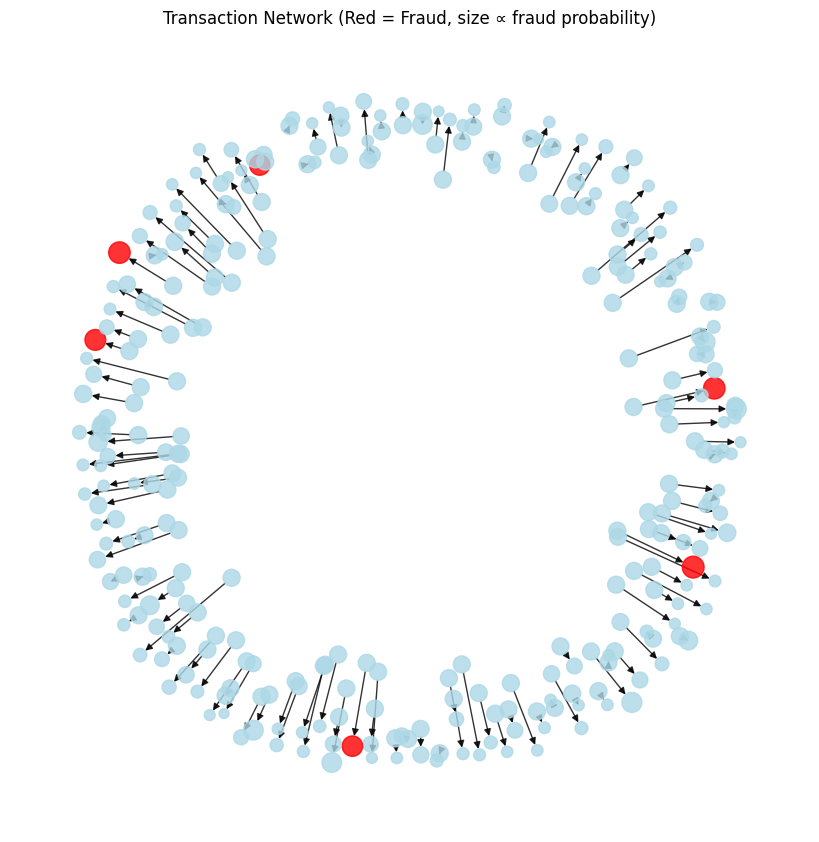

In [37]:
# Node color and size based on prediction
colors = ['red' if pred[i] == 1 else 'lightblue' for i in sub_nodes]
sizes = [50 + probs[i].item() * 200 for i in sub_nodes]

plt.figure(figsize=(8,8))
nx.draw(subG, node_color=colors, node_size=sizes, with_labels=False, alpha=0.8)
plt.title("Transaction Network (Red = Fraud, size ∝ fraud probability)")
plt.show()

In [38]:
from google.colab import drive
import pandas as pd

In [39]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
!ls /content/drive/MyDrive/FinanceProject/

FraudData.csv  TrustLedger.ipynb
